In [1]:
from google.colab import files
uploaded = files.upload()


Saving forestfires.csv to forestfires.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load dataset
df = pd.read_csv("forestfires.csv")

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=["month", "day"], drop_first=True)

# Separate features and target
features = df.drop('area', axis=1)
target = df['area']

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Recreate dataframe
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['area'] = target


In [3]:
# Log-transform the target
df_scaled['log_area'] = np.log1p(df_scaled['area'])

# Prepare data for model
X = df_scaled.drop(['area', 'log_area'], axis=1)
y = df_scaled['log_area']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



📊 Model Evaluation:
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 2.3129
RMSE: 1.5208
R² Score: -0.0524


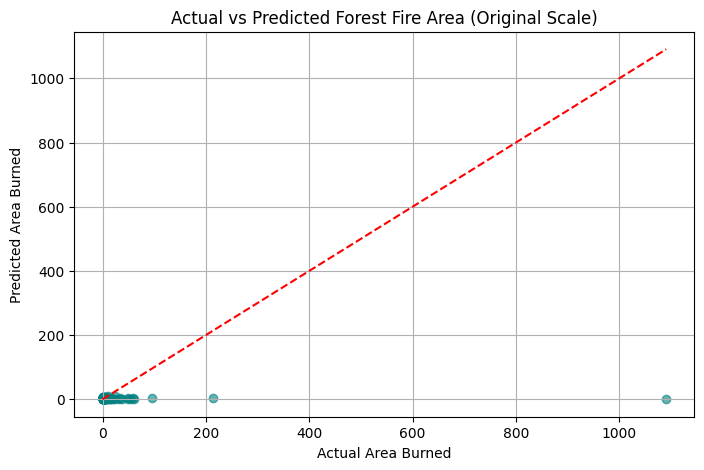

In [5]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print("Best Parameters:", grid_search.best_params_)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Convert back to original scale
actual_area = np.expm1(y_test)
predicted_area = np.expm1(y_pred)

# Plot actual vs predicted
plt.figure(figsize=(8,5))
plt.scatter(actual_area, predicted_area, color='teal', alpha=0.6)
plt.plot([0, max(actual_area)], [0, max(actual_area)], color='red', linestyle='--')
plt.xlabel("Actual Area Burned")
plt.ylabel("Predicted Area Burned")
plt.title("Actual vs Predicted Forest Fire Area (Original Scale)")
plt.grid(True)
plt.show()


In [6]:
# Save model
joblib.dump(best_model, 'forest_fire_model.pkl')
print("✅ Model saved as forest_fire_model.pkl")

# Download model to your computer
files.download('forest_fire_model.pkl')


✅ Model saved as forest_fire_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Ask for state name (simulate filtering)
state_input = input("Enter the name of the state you want prediction for: ").strip().lower()


Enter the name of the state you want prediction for: 1



📍 Predicted Forest Fire Stats for '1':
🔸 Average Actual Area Burned: 10.91
🔸 Average Predicted Area Burned: 3.06


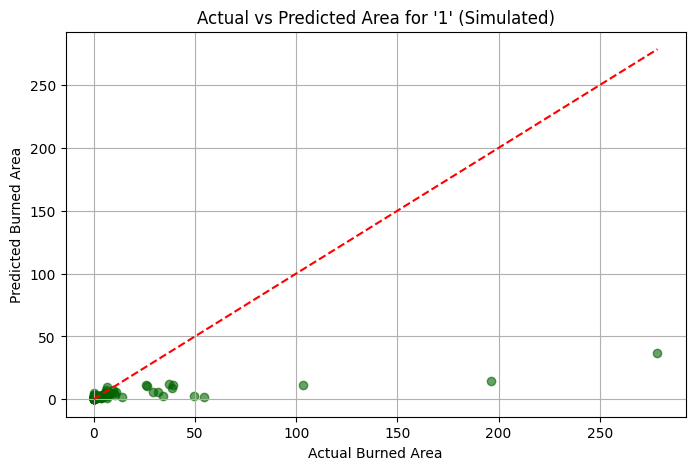

In [12]:
# Simulate state-wise prediction using a subset of data
# For demo, we’ll just randomly select a chunk based on user input

import hashlib

# Convert state name to a number for consistent random sampling
seed_value = int(hashlib.sha256(state_input.encode()).hexdigest(), 16) % (10**6)
subset_df = df_scaled.sample(frac=0.2, random_state=seed_value)

# Prepare data
X_subset = subset_df.drop(['area', 'log_area'], axis=1)
y_subset = subset_df['log_area']

# Predict
pred_subset = best_model.predict(X_subset)

# Convert back to original area scale
actual_area = np.expm1(y_subset)
predicted_area = np.expm1(pred_subset)

# Show average prediction result
print(f"\n📍 Predicted Forest Fire Stats for '{state_input.title()}':")
print(f"🔸 Average Actual Area Burned: {actual_area.mean():.2f}")
print(f"🔸 Average Predicted Area Burned: {predicted_area.mean():.2f}")

# Optional: Plot
plt.figure(figsize=(8,5))
plt.scatter(actual_area, predicted_area, alpha=0.6, color='darkgreen')
plt.plot([0, max(actual_area)], [0, max(actual_area)], color='red', linestyle='--')
plt.xlabel("Actual Burned Area")
plt.ylabel("Predicted Burned Area")
plt.title(f"Actual vs Predicted Area for '{state_input.title()}' (Simulated)")
plt.grid(True)
plt.show()
